## PLN em notícias do Diário do Nordeste

Esse notebook tem o intuito de utilizar processamento de linguagem natural para analisar e agrupar notícias do Diário do Nordeste considerando o editorial pertencente. É necessário tratar as notícias para a realização do processo de agrupamento, e porteriormente, classificação. A seguir estão as etapas que forão realizadas:

- Tokenizar
- Normalizar
- Remoção de stopwords
- Stemming
- Cálculo do termo-documento (TF-IDF)
- Cálculo do centróide para cada editorial (*Rocchio classifier*)
- Cálculo da distância média ao centróide 

Vamos começar!

In [1]:
#Bibliotecas utilizadas
import csv
import pandas as pd
import numpy as np
import nltk
import math
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import vega
#from vega_datasets import data
import altair as alt
alt.renderers.enable('notebook')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anaal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anaal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


RendererRegistry.enable('notebook')

In [2]:
#Baixando as Stopwords e Stemming em português:
stemmer = SnowballStemmer('portuguese')
stopwords = nltk.corpus.stopwords.words('portuguese')

# acrescentando algumas palavras para stopwords
stopwords.append("r")
stopwords.append("a")
stopwords.append("o")
stopwords.append("``")
stopwords.append("\'\'")

### Sobre os dados

In [3]:
# Importando as notícias
dados = pd.read_csv('noticias.csv',encoding='utf-8') #acrescentar encoding='utf-8'
dados.head(10)

,editorial,texto,titulo,data,autor
0,Jogada,"A delegação do Liverpool já voltou para casa, ...",Alisson exalta atuação de Firmino no Mundial: ...,2019-12-23 12:08:31,Conteúdo Estadão
1,Jogada,Recentemente contratado para o cargo técnico d...,Abel Braga estuda entrar na Justiça para exigi...,2019-12-23 11:39:54,Redação
2,Jogada,Com passagem pelas categorias de base do Ceará...,Vice-presidente do Flamengo publica foto de jo...,2019-12-23 10:48:00,Redação
3,Jogada,Mateus Gonçalves fica no Ceará para 2020! O at...,Mateus Gonçalves confirma renovação com o Cear...,2019-12-23 09:05:00,Redação
4,Jogada,"Com uma derrota por 4 a 2 para o Caucaia, no E...","Com velhos conhecidos, Icasa busca retornar ao...",2019-12-23 00:00:00,Antônio Rodrigues
5,Jogada,A torcida do Ceará já está acostumada a confer...,Vai ter presente? Veja quem o Ceará deve anunc...,2019-12-23 00:00:00,Gustavo de Negreiros
6,Jogada,O jogo já estava 2 a 0 para o Chelsea sobre o ...,"Rüdiger, do Chelsea, é vítima de racismo em cl...",2019-12-22 19:02:12,Folha Press
7,Jogada,Três dias após conquistar seu primeiro título ...,"""Prefiro não jogar esse jogo"", diz Italo Ferre...",2019-12-22 18:50:00,Folha Press
8,Jogada,"De olho nos Jogos Olímpicos de Tóquio, em 2020...","De olho nos Jogos de Tóquio, seleção feminina ...",2019-12-22 18:43:00,Conteúdo Estadão
9,Jogada,"Já trabalhando para a temporada de 2020, onde ...",Ferroviário é derrotado pelo Potiguar-RN em am...,2019-12-22 18:19:00,Redação


In [4]:
print("Quantidade de notícias/documentos importados: ", len(dados))

Quantidade de notícias/documentos importados:  2168


**Editorias com maior número de notícias:**

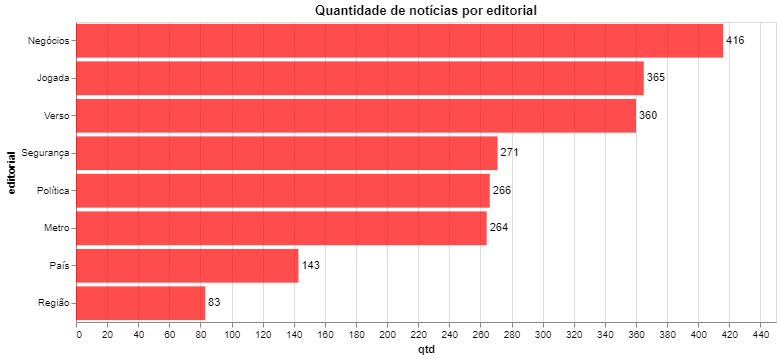

In [5]:
df_edi=dados.groupby('editorial').size().sort_values(ascending=False).reset_index().rename(columns={0:'qtd'})
chart=alt.Chart(df_edi).mark_bar(
    color='red',
    opacity=0.7
    ).encode(
        x='qtd',
        y=alt.Y('editorial', sort='-x')
    ).properties(
            title='Quantidade de notícias por editorial',
            height = 300,
            width = 700,
            )

text = chart.mark_text(
        align='left',
        baseline='middle',
        dx=3  
    ).encode(
            text='qtd'
        )

chart_final=(chart + text)#.properties(height=300, width=850)
chart_final.save('frequencia_editorial.html')
chart_final


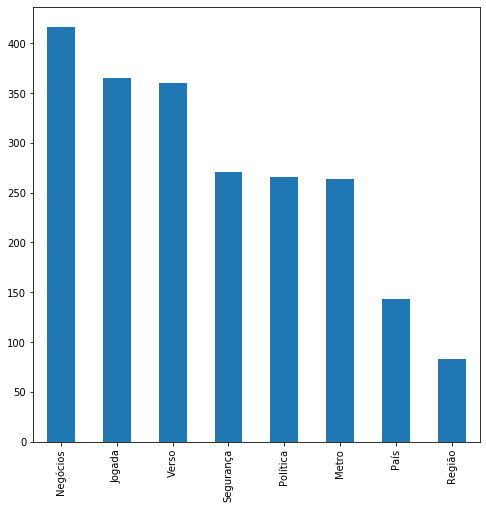

In [6]:
dados['editorial'].value_counts().head(10).plot(kind='bar',figsize=(8,8))

### Tratamento das notícias

In [6]:
noticias=dados['texto']

In [7]:
#Removendo stopwords,"tokenizando", aplicando stemmer e removendo caracteres indesejáveis
undesired = [',','.',"'",'"','´','`',';',':','-','?','!','%','(',')','\t','\n','\\','//','$','-','“']
noticias_tratadas = []
for k in noticias:
    token=nltk.word_tokenize(k, language='portuguese')
    token_norm=[palavra.lower() for palavra in token if palavra.isalpha()]
    token_stem=[stemmer.stem(palavra) for palavra in token_norm if palavra not in stopwords and not palavra in undesired ]
    noticias_tratadas.append(" ".join(token_stem))
    
dados['texto']=noticias_tratadas

Após o tratamento as notícias ficam dessa forma:

In [8]:
dados.iloc[0,1]

'deleg liverpool volt cas após conquist mundial club doh cat clim fest aind acab desembarqu goleir alisson elogi qualidad robert firmin companheir seleçã brasileir após gols decis marc marc gols vitór liverpool tant semifinal contr monterrey quant final contr flameng sáb decisã gol saiu soment primeir temp prorrog demonstr nervos ansiedad firmin aproveit tim inglês dribl rodrig cai goleir dieg alves vez bat red qualidad bobby diss goleir apel firmin club inglês moviment calm diant gol trein entã trein assim concentr cheg gram faz cois cert feliz ter marc car merec tud feliz junt firmin alisson conquist quatr títul ano send seleçã brasileir cop amér levant troféu lig campeõ supercop europ agor mundial club quant títul club faz part primeir tim inglês obter três conquist ano quebr lev liverpool primeir títul mundial incrível primeir tim dest club sagr campeã mundial comemor alisson feliz estar aqu estar traz troféu cidad club amam futebol amam jog cad tornei vir futur após desembarc sol 

### Cálculo TF-IDF

Primeiro vamos criar uma matriz que possui a contagem das palavras em cada notícia (*Bag of words*). 

In [9]:
cv = CountVectorizer()
matriz_freq = cv.fit_transform(noticias_tratadas)
print('O corpus possui', matriz_freq.shape[1], 'tokens, ou seja, a matriz resultante possui essa quantidade de colunas.')
print('A matriz possui', matriz_freq.shape[0], 'linhas, representando cada notícia/documento.')

O corpus possui 20326 tokens, ou seja, a matriz resultante possui essa quantidade de colunas.
A matriz possui 2168 linhas, representando cada notícia/documento.


Em seguida, a função *TfidfTransformer* calcula o TF-IDF:

In [10]:
#Calcula o TF-IDF para cada token
tf_idf = TfidfTransformer(use_idf=True).fit(matriz_freq)
#Implementa os valores nos respectivos índices da matriz
text_tf_idf = tf_idf.transform(matriz_freq)

### Cálculo do centróide para cada editorial

Separação das notícias em treino e teste:

In [11]:
text_tf_idf_train, text_tf_idf_test, editoriais_train, editoriais_test = train_test_split(text_tf_idf, dados['editorial'], test_size=0.25, random_state=0)

Cálculo dos centróides com a base de treino:

In [12]:
noticias = dados.texto[editoriais_train.index]
editoriais = editoriais_train

#calculando centróides de cada editorial no espaço do tfidf
modelo = NearestCentroid().fit(text_tf_idf_train, editoriais)
centroides = modelo.centroids_

Valores preditos no teste:

In [13]:
prediction=modelo.predict(text_tf_idf_test.toarray())
print('A acurácia do teste é de', 100*accuracy_score(editoriais_test, prediction))

A acurácia do teste é de 80.44280442804428


### Cálculo da distância média ao centroide em cada editorial:

In [14]:
#calculando a distância média das notícias de um editorial para seu centróide
for (editorial, centroide) in zip(modelo.classes_, centroides):
  #obtendo índices das notícias de um editorial
  indices = editoriais[editoriais==editorial].index.values
  #obtendo as notícias do editorial
  noticias_editorial = text_tf_idf[indices]
  #calculando a distância de cada notícia ao centróide
  distancias = [np.linalg.norm(n - centroide) for n in noticias_editorial[:,:]]
  #tirando a média das distâncias
  media = np.mean(distancias)

  print("Distância média ao centroide das {} noticias do editorial {}: {}".format(noticias_editorial.shape[0], editorial, media))

Distância média ao centroide das 272 noticias do editorial Jogada: 0.9448251498359613
Distância média ao centroide das 191 noticias do editorial Metro: 0.972320173102721
Distância média ao centroide das 316 noticias do editorial Negócios: 0.9694605952470875
Distância média ao centroide das 111 noticias do editorial País: 0.97349847423664
Distância média ao centroide das 203 noticias do editorial Política: 0.9537168519546201
Distância média ao centroide das 58 noticias do editorial Região: 0.9632093507971093
Distância média ao centroide das 199 noticias do editorial Segurança: 0.9536789586284118
Distância média ao centroide das 276 noticias do editorial Verso: 0.9781001405778365
